# Keyword Spotting with CNNs

In [1]:
#imports
import numpy as np
from python_speech_features import mfcc, delta, logfbank
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import join as pjoin
import pickle

### Data preprocessing

AUDIO length = 1.0s


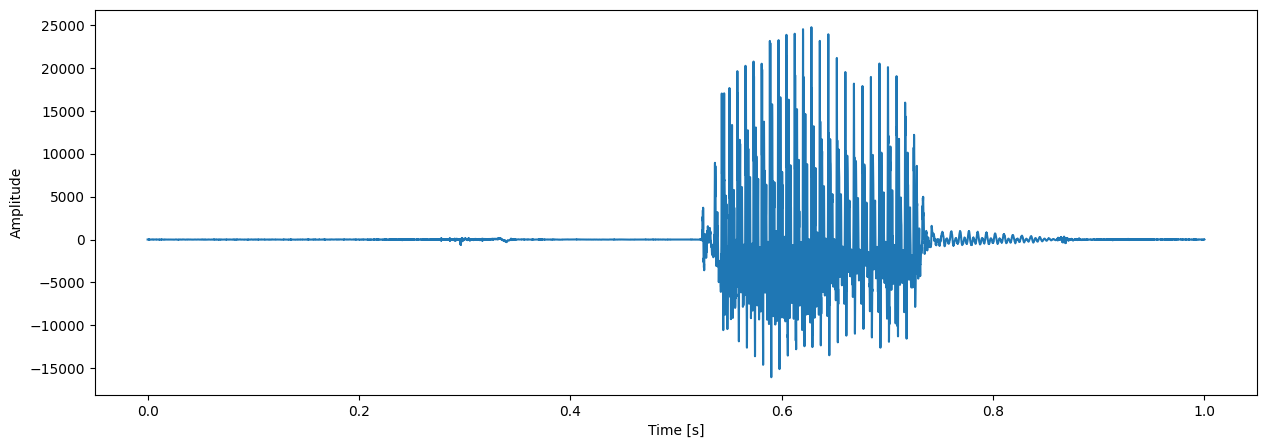

In [2]:
# Test with one file
samplerate, signl = wav.read("/mnt/speechdataset/bed/00176480_nohash_0.wav")
signal_length = signl.shape[0]/samplerate

print(f"AUDIO length = {signal_length}s")

# Plot the audio signal
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(np.linspace(0., signal_length, len(signl)), signl)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [3]:
# MFCCs of the signal
mfcc_feat_E = mfcc(signal=signl, samplerate=samplerate, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=512,
                lowfreq=0, appendEnergy=True)
mfcc_feat = mfcc(signal=signl, samplerate=samplerate, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=512,
                lowfreq=0, appendEnergy=False)
d_mfcc_feat = delta(mfcc_feat, 2)
d2_mfcc_feat = delta(d_mfcc_feat, 2)
fbank_feat = logfbank(signl, samplerate)


print('MFCCs shape:', np.shape(mfcc_feat_E))
print('Deltas shape:', np.shape(d_mfcc_feat))
print('Delta-delta shape:', np.shape(d2_mfcc_feat))
print('All features shape:', np.shape(np.concatenate((mfcc_feat, d_mfcc_feat, d2_mfcc_feat), axis=1)))

MFCCs shape: (99, 13)
Deltas shape: (99, 13)
Delta-delta shape: (99, 13)
All features shape: (99, 39)


In [ ]:
# Data loading
# Folder directories
data_dir = '/mnt/speechdataset/'
keywords = ['bed', 'down', 'forward', 'house', 'nine', 'one', 'six', 'tree', 'visual', 'bird', 'eight', 'four', 'learn', 'no',
            'right', 'stop', 'two', 'wow', 'cat', 'five', 'go', 'left', 'off', 'seven', 'up', 'yes', 'backward', 'dog', 
            'follow', 'happy', 'marvin', 'on', 'sheila', 'three', 'zero']

# Processed data storing unit
feature_dict = {}

# Parameters
window_len = 0.025 #s
window_step = 0.01 #s
num_coefs = 13 # keep cepstral coefs 1 to 'num_coefs'; when appendEnergy=True the 1st coef is the log-energy
num_filters = 26 

# Go through all the available files and find their audio features
for keyword in keywords:
    folder_path = Path(pjoin(data_dir, keyword))
    folder_features = np.zeros((1,39))
    for wav_file in folder_path.glob('*.wav'):
        samplerate, signl = wav.read(wav_file)
        # MFCCs
        mfcc_feat = mfcc(signal=signl, samplerate=samplerate, winlen=window_len, winstep=window_step,
                         numcep=num_coefs, nfilt=num_filters, nfft=512, lowfreq=0, appendEnergy=True)
        # Delta coefs
        d_mfcc_feat = delta(mfcc_feat, 2)
        # Delta-Delta coefs
        d2_mfcc_feat = delta(d_mfcc_feat, 2)
        # save Audio features
        file_features = np.concatenate((mfcc_feat, d_mfcc_feat, d2_mfcc_feat), axis=1)
        folder_features = np.concatenate((folder_features, file_features), axis=0)
    feature_dict[keyword] = np.delete(folder_features, (0), axis=0)
    
# duda energias

The data is stored in the form of a dictionary: 
* Key: keywords recorded in the different audiofiles 
* Values: audio features correspondig to the frames of every audiofile of a certain keyword. They are stored as a 2D-array of size (_totalframes_ x _features_). The features follow the order _log-energy (1), MFCCs (12), delta-coefs (13), delta-delta-coefs (13)_.

In [6]:
feature_dict

{'bed': array([[  8.12859399, -12.09801316, -12.57091597, ...,   0.75012059,
           0.18236974,  -0.27591115],
        [  8.16594865, -11.29186841, -12.21419591, ...,   0.30618055,
           0.02265553,   0.13741293],
        [  8.02320008, -11.32740554, -11.58812586, ...,  -0.92213209,
          -0.37428149,   0.79416803],
        ...,
        [  5.1132639 , -11.62016754,  -9.67309119, ...,   0.5738247 ,
           0.35335476,   1.4340246 ],
        [  4.87852143, -16.06634379,  -9.11295732, ...,   0.93434405,
           0.1022052 ,   0.85642767],
        [  4.06487943, -19.31159994,   3.72099261, ...,   0.94999732,
          -0.11447926,   0.20843257]]),
 'down': array([[  6.36020136, -27.91885748, -16.29532471, ...,   0.80047118,
          -0.38492878,  -0.88895262],
        [  6.39716457, -28.65757292, -15.67349489, ...,   2.38864898,
           0.3719791 ,  -0.84328681],
        [  6.07562774, -26.93528281, -16.05160132, ...,   3.11034297,
           1.33424852,  -0.06227553]

In [ ]:
f = open("/mnt/speechdataset/processed_audio_features.pkl","wb")
pickle.dump(feature_dict, f)
f.close()